In [14]:
# Required Header
!pip install matplotlib networkx numpy gymnasium scikit-learn stable-baselines3
%matplotlib inline

import networkx as nx
import numpy as np
from gymnasium import Env
from gymnasium.spaces import Box, MultiBinary
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

  Using cached torch-2.5.1-cp312-cp312-win_amd64.whl.metadata (28 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
Using cached torch-2.5.1-cp312-cp312-win_amd64.whl (203.0 MB)
Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)
   ---------------------------------------- 0.0/11.5 MB ? eta -:--:--
   ---------- ----------------------------- 2.9/11.5 MB 14.0 MB/s eta 0:00:01
   -------------------- ------------------- 6.0/11.5 MB 14.8 MB/s eta 0:00:01
   ------------------------------- -------- 9.2/11.5 MB 15.0 MB/s eta 0:00:01
   ---------------------------------------- 11.5/11.5 MB 14.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/536.2 kB ? eta -:--:--
   --------------------------------------- 536.2/536.2 kB 18.3 MB/s eta 0:00:00


In [22]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from gymnasium import Env
from gymnasium.spaces import Box, MultiBinary

# Define Graph Environment
class GraphEnv(Env):
    def __init__(self, graph, alpha=0.1, gamma=0.9, epsilon=0.1):
        super(GraphEnv, self).__init__()
        self.graph = graph
        self.max_nodes = len(graph.nodes)
        self.action_space = MultiBinary(self.max_nodes)
        self.observation_space = Box(low=0, high=1, shape=(self.max_nodes, 2), dtype=np.float32)
        self.state = self.get_padded_state()
        
        # Q-learning parameters
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.q_table = {}  # Initialize Q-table

    def get_padded_state(self):
        """Get the padded state for the current graph."""
        degrees = np.array([deg for _, deg in self.graph.degree()])
        clustering = np.array(list(nx.clustering(self.graph).values()))
        max_degree = max(degrees) if len(degrees) > 0 else 1
        
        # Avoid division by zero
        if max_degree == 0:
            max_degree = 1
        
        # Normalize and stack features
        state = np.stack([degrees / max_degree, clustering], axis=1)

        # Pad the state to maintain consistent shape
        padding = self.max_nodes - state.shape[0]
        if padding > 0:
            state = np.vstack([state, np.zeros((padding, 2))])
        return state

    def reset(self, seed=None, options=None):
        """Reset the environment to its initial state."""
        if seed is not None:
            np.random.seed(seed)
        self.graph = nx.erdos_renyi_graph(self.max_nodes, 0.1)  # Reset to a random graph
        self.state = self.get_padded_state()
        return self.state, {}

    def compute_properties(self, graph):
        """Compute properties of a given graph."""
        return {
            "clustering": nx.average_clustering(graph),
        }

    def step(self, action):
        """Take a step by selecting a subset of nodes and predicting clustering."""
        subset_nodes = [node for i, node in enumerate(self.graph.nodes) if action[i] == 1]
    
        if not subset_nodes:  # If no nodes are selected, return penalty
            info = {
                "predicted_properties": None,
                "actual_properties": None,
                "error": "Empty subset selected",
            }
            return self.state, -1, False, False, info
    
        # Compute actual clustering for the subset
        subgraph = self.graph.subgraph(subset_nodes)
        actual_properties = self.compute_properties(subgraph)
        actual_clustering = actual_properties["clustering"]
    
        # Normalize the clustering coefficient to be between 0 and 1
        reward = actual_clustering / 1.0  # Clustering coefficient is already between 0 and 1

        done = False  # Task does not terminate in this setup
        info = {
            "actual_properties": actual_properties,
        }
        return self.state, reward, done, False, info

    def update_q_table(self, state, action, reward, next_state):
        """Update Q-table using Q-learning update rule."""
        state_key = tuple(state.flatten())
        next_state_key = tuple(next_state.flatten())
        action_key = tuple(action)

        if state_key not in self.q_table:
            self.q_table[state_key] = {}
        if action_key not in self.q_table[state_key]:
            self.q_table[state_key][action_key] = 0

        if next_state_key not in self.q_table:
            self.q_table[next_state_key] = {}
        max_next_q = max(self.q_table[next_state_key].values(), default=0)

        # Q-learning update rule
        self.q_table[state_key][action_key] += self.alpha * (reward + self.gamma * max_next_q - self.q_table[state_key][action_key])

    def select_action(self, state):
        """Select action using epsilon-greedy policy."""
        state_key = tuple(state.flatten())
        if np.random.rand() < self.epsilon or state_key not in self.q_table:
            return self.action_space.sample()  # Explore: random action
        else:
            # Exploit: select action with highest Q-value
            return max(self.q_table[state_key], key=self.q_table[state_key].get)

Episode: 0, Total Reward: 0.0, Cumulative Average Accuracy: 0.0
Episode: 1, Total Reward: 0.0, Cumulative Average Accuracy: 0.0
Episode: 2, Total Reward: 0.0, Cumulative Average Accuracy: 0.0
Episode: 3, Total Reward: 0.0, Cumulative Average Accuracy: 0.0
Episode: 4, Total Reward: 0.0, Cumulative Average Accuracy: 0.0
Episode: 5, Total Reward: 0.0, Cumulative Average Accuracy: 0.0
Episode: 6, Total Reward: 0.0, Cumulative Average Accuracy: 0.0
Episode: 7, Total Reward: 0.0, Cumulative Average Accuracy: 0.0
Episode: 8, Total Reward: 0.0, Cumulative Average Accuracy: 0.0
Episode: 9, Total Reward: 0.0, Cumulative Average Accuracy: 0.0
Episode: 10, Total Reward: 0.0, Cumulative Average Accuracy: 0.0
Episode: 11, Total Reward: 0.0, Cumulative Average Accuracy: 0.0
Episode: 12, Total Reward: 0.0, Cumulative Average Accuracy: 0.0
Episode: 13, Total Reward: 0.0, Cumulative Average Accuracy: 0.0
Episode: 14, Total Reward: 0.0, Cumulative Average Accuracy: 0.0
Episode: 15, Total Reward: 0.0, Cum

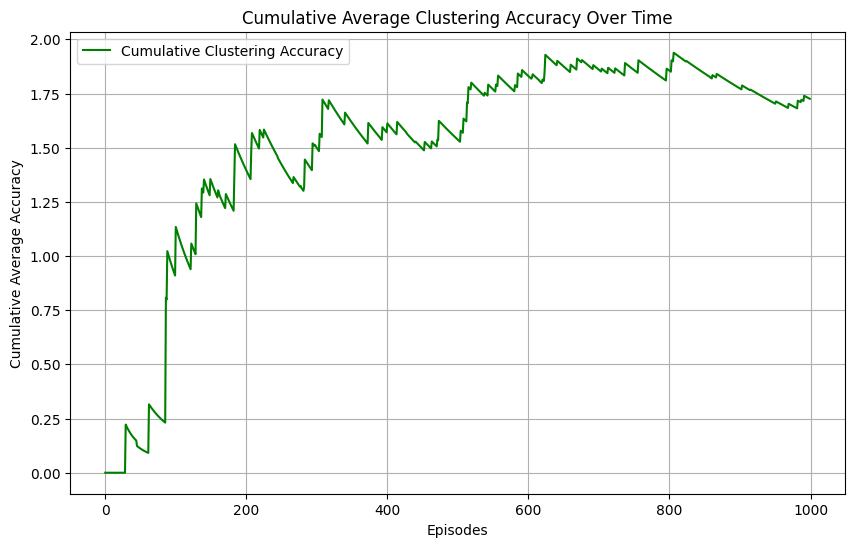

In [23]:
# Create a smaller graph for testing
graph = nx.erdos_renyi_graph(10, 0.3)
env = GraphEnv(graph)

# Reset the environment
obs, _ = env.reset()

# Initialize cumulative sum variables
clustering_accuracy_sum = 0

# Lists to store cumulative average accuracies for each metric over time
clustering_accuracy_cumulative = []

# Train with Q-learning
for episode in range(1000):
    state, _ = env.reset()
    total_reward = 0

    for step in range(100):
        action = env.select_action(state)  # Select action using epsilon-greedy policy
        next_state, reward, done, _, info = env.step(action)
        env.update_q_table(state, action, reward, next_state)  # Update Q-table

        total_reward += reward
        state = next_state

        if done:
            break

    # Calculate cumulative average accuracy
    clustering_accuracy_sum += total_reward
    clustering_accuracy_cumulative.append(clustering_accuracy_sum / (episode + 1))

    # Debug prints to check values
    print(f"Episode: {episode}, Total Reward: {total_reward}, Cumulative Average Accuracy: {clustering_accuracy_cumulative[-1]}")

# After the loop, plot the cumulative average accuracy for clustering over time
plt.figure(figsize=(10, 6))

# Plot cumulative average accuracy line
plt.plot(clustering_accuracy_cumulative, label='Cumulative Clustering Accuracy', color='green')

# Add labels and title
plt.xlabel('Episodes')
plt.ylabel('Cumulative Average Accuracy')
plt.title('Cumulative Average Clustering Accuracy Over Time')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()